In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle

In [7]:
from src.model_pipeline import clean_data

In [8]:
#gather data for unsupervised learning
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/jiaqis/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Preprocessing
- Apply the wrangling method in data_wrangling section

In [9]:
azdias_clean = clean_data(azdias)

Dataset has 0 missing value.


In [10]:
customers_clean = clean_data(customers)
customers_clean_nolabel = customers_clean.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

Dataset has 0 missing value.


In [11]:
# set label for customer and non-customer
azdias_clean['y'] = 0
customers_clean_nolabel['y'] = 1
df = azdias_clean.append(customers_clean_nolabel, ignore_index=True)
X = df[[col for col in df.columns if col not in ['LNR', 'y' ]]]
y = df['y']

## PCA
- Utilize PCA algorithm to reduce dimension

In [12]:
# Standar Scaler before apply PCA
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

In [13]:
ratio_list = []

# Get explained variance of differenct n component
for i in range(X_norm.shape[1]):
    pca = PCA(n_components=i+1)
    pca.fit(X_norm)
    explained_variance_ratio_sum = pca.explained_variance_ratio_.sum()
    ratio_list.append(explained_variance_ratio_sum)
    #print(f'{i+1} components explains {explained_variance_ratio_sum} of variance.')
    
file = open("src/pca_explain_variance.plk", "wb")
pickle.dump(ratio_list, file)
file.close()

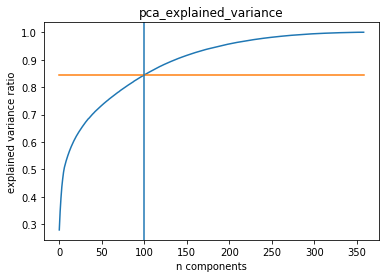

0.8427815209037445

In [55]:
# draw the chart to find the optimal n_components
file = open("src/pca_explain_variance.plk",'rb')
pca_explain_variance = pickle.load(file)
plt.title('pca_explained_variance')
plt.ylabel('explained variance ratio')
plt.xlabel('n components')
plt.plot(pca_explain_variance)
plt.plot(np.full(len(pca_explain_variance), pca_explain_variance[99]))
plt.axvline(x=100)
plt.show()
pca_explain_variance[99]

#### As the graph shows, 100 component can explain 85% variance, so we take reduce our deminsion to 100.

## K-Means
 - Utilize K-means to divide population and find the attributes representing company customer

In [17]:
# reduce dimension before clustering
pca = PCA(n_components=100)
reduced_data = pca.fit_transform(X_norm)

In [21]:
mss_list = []

# Get MSS of differenct K
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_data)
    mss = kmeans.inertia_
    mss_list.append(mss)
    #print(f'{k} clusters sum of distances is {mss}.')
    
file = open("src/kmean_mss.plk", "wb")
pickle.dump(mss_list, file)
file.close()

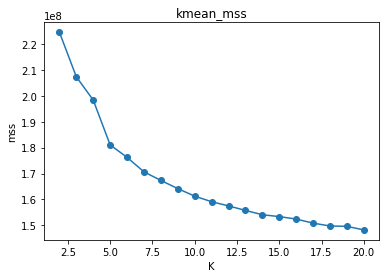

In [14]:
# Draw the mss chart to find the optimal K
file = open("src/kmean_mss.plk",'rb')
kmean_mss = pickle.load(file)
plt.title('kmean_mss')
plt.ylabel('mss')
plt.xlabel('K')
plt.plot(range(2,21), kmean_mss, '-o')
plt.show()

#### - Select 5 groups according to elblow theory.
#### - Try 17 groups if 5 not working because the curve start to flat at 17

In [22]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(reduced_data)
y_pred = kmeans.predict(reduced_data)

group_5_result = pd.DataFrame({
    'y_actual': y,
    'y_group': y_pred,
})

In [23]:
# Get the customer percentage in population
group_5_result_mean = group_5_result.groupby(['y_group']).mean()

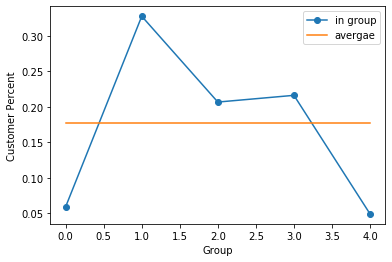

In [46]:
l1, = plt.plot(range(5), group_5_result_mean, '-o')
l2, = plt.plot(np.full(len(group_5_result_mean), group_5_result.mean()['y_actual']))
plt.legend(handles=[l1,l2],labels=['in group', 'avergae'])
plt.ylabel('Customer Percent')
plt.xlabel('Group')
plt.show()

 - Can not get clear info from above, so try 17 groups

In [37]:
kmeans = KMeans(n_clusters=17)
kmeans.fit(reduced_data)
y_pred = kmeans.predict(reduced_data)

group_17_result = pd.DataFrame({
    'y_actual': y,
    'y_group': y_pred,
})

In [38]:
group_17_result_mean = group_17_result.groupby(['y_group']).mean()

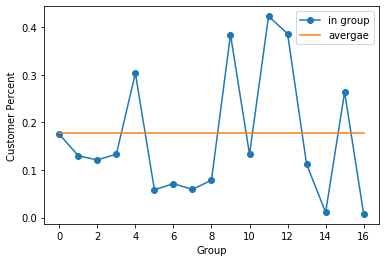

In [47]:
l1, = plt.plot(range(17), group_17_result_mean, '-o')
l2, = plt.plot(np.full(len(group_17_result_mean), group_17_result.mean()['y_actual']))
plt.legend(handles=[l1,l2],labels=['in group', 'avergae'])
plt.ylabel('Customer Percent')
plt.xlabel('Group')
plt.show()

 - Target group: 9, 11, 12
 - Non Target Group: 14, 16

### Check first 10 component in target group and non target group

In [82]:
def pca_cluster_centers_in_group(group_number, target_color, component_number= 10):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    for i in range(17):
        #target group
        if i == group_number:
            color =  target_color
            l1, = ax.plot(kmeans.cluster_centers_[i, :component_number], color)
        else:
            color = 'lightgrey' 
            l2, = ax.plot(kmeans.cluster_centers_[i, :component_number], color)

    lmean, = ax.plot(kmeans.cluster_centers_.mean(axis=1)[:component_number], 'black')
    plt.legend(handles=[l1,l2, lmean],labels=['target', 'other', 'mean'])
    ax.set_title('Group' + str(group_number))
    ax.set_ylabel('cluster_centers_')
    ax.set_xlabel('component')

    return fig

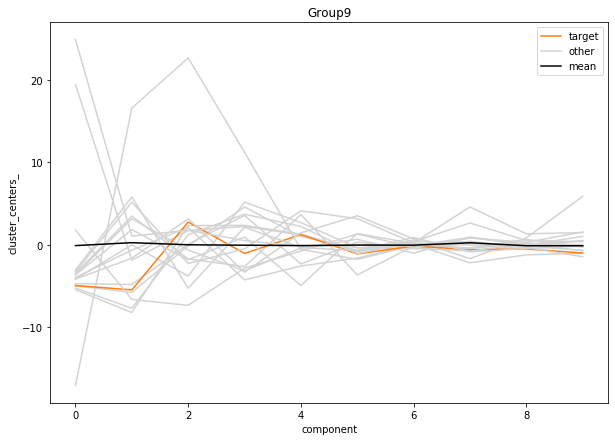

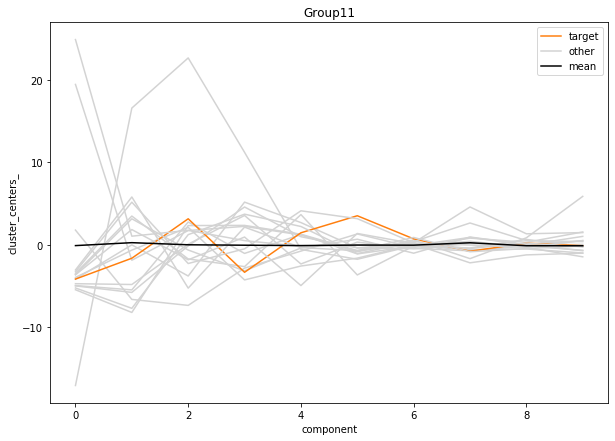

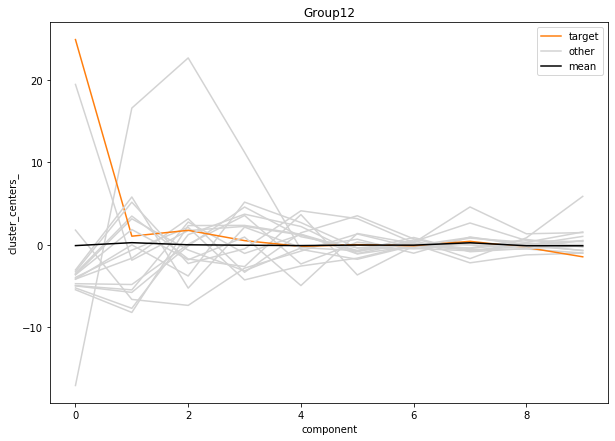

In [83]:
for group_number in [9, 11, 12]:
    pca_cluster_centers_in_group(group_number, 'tab:orange')

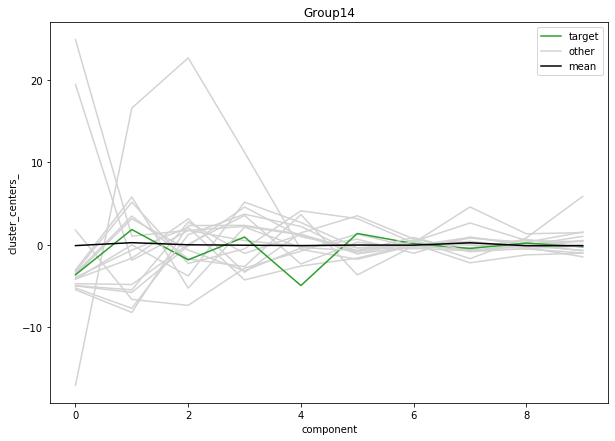

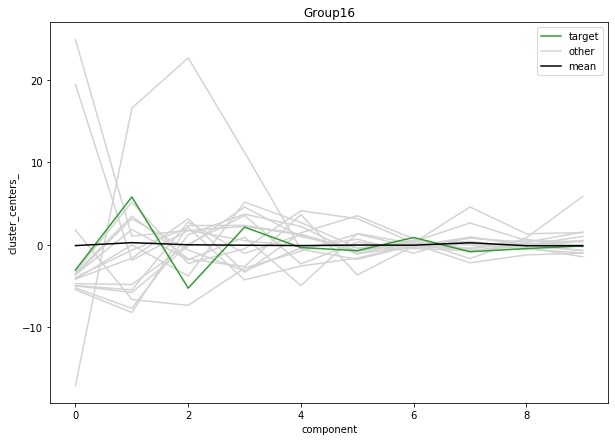

In [79]:
for group_number in [14, 16]:
    pca_cluster_centers_in_group(group_number, 'tab:green')

#### Orange line is target group, green line is non-target group, can not get meaningful result because of different variance in each group. 
But Group 12 give us the insights that this target group have high first pca component value, so we  dig into the loading of this component.

In [57]:
# Find the loading in the group
component_number = 1
pd.DataFrame({
    'Attribute': [col for col in df.columns if col not in ['LNR', 'y' ]],
    'Loading': pca.components_.T[:, component_number],
    'Abs_loading': abs(pca.components_.T[:, component_number])
}).sort_values(by='Abs_loading', ascending=False).head(10)

,Attribute,Loading,Abs_loading
44,D19_GESAMT_ANZ_24,-0.138169,0.138169
45,D19_GESAMT_DATUM,0.136522,0.136522
76,D19_VERSAND_DATUM,0.133098,0.133098
43,D19_GESAMT_ANZ_12,-0.129665,0.129665
47,D19_GESAMT_ONLINE_DATUM,0.129631,0.129631
75,D19_VERSAND_ANZ_24,-0.129445,0.129445
78,D19_VERSAND_ONLINE_DATUM,0.125678,0.125678
307,ONLINE_AFFINITAET,-0.125446,0.125446
53,D19_KONSUMTYP_MAX,0.125044,0.125044
299,LP_LEBENSPHASE_FEIN,-0.121855,0.121855


### From the loading we can find that out target customers are the people who has **frequent transaction avtivities**.